**Disclaimer: No real data! It doesn't relates to any real mine I have been involved. This is only an exercise to put in practice OOP and a few simulation concepts**

This an attemp to model the operation of a mine. The geological setting is a sedimentary, flat layered deposit. It is comprised of 4 seams: overburden, seam1, seam2 and seam3. For this example seam2 is considered waste. This exercise considers that geological modeling and pit design has been completed. Volumes for the seam are unitless.

The mine shift is 6 days 1, 1 day off. There is only 1 excavator on site, the number of trucks was not considered in this exercise for the sake of brevity. 

Daily extraction, if ore, goes to a stockpile, while waste material to a dump. Stockpile volumes was considered in this example, while dump capacity, though importan to model, was out of the scope.

The stockpile feeds a plant. The plant runs 7 days a week, 365 days. Plant stops for maintenance or suddens failures were not included in the simulation.

In order to run this exercise, it is considerd that the plant produces one product type. No sales of final product included, inventory is acumulated.

The scope of the simulation is to investigate how long it could take the stripping, deplete the cut, how often the stockpile has no available ore and the plant is idle. The simulation stops when the silo al the plant is empty and no more ore in the ground or in the stockpile is available.

# Connecting to Ops data

Firts, let assume that the mine operation departments uses Google Sheets for data capture. These values will be used to fine tune the simulation, in order to provide a better forecasts learning from previous data.

To achieve the former, data would be imported following the next piece of code shown in the example of this [link.](https://colab.research.google.com/drive/1-gYY4UsVCtldK-pXbGVi-QdBuSunljvN?usp=sharing)

In [ ]:
!pip install --upgrade gspread

In [29]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

In [30]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('DailyHaul').sheet1

# get_all_values gives a list of rows.
hauling = worksheet.get_all_values()


# Convert to a DataFrame and render.
import pandas as pd
mine_prod = pd.DataFrame(hauling)
mine_prod.columns = mine_prod.iloc[0]
mine_prod = mine_prod.iloc[1:]

In [31]:
mine_prod.head()

,Day,Haul,Material
1,1,56,ob
2,2,23,ob
3,3,43,ob
4,4,64,ob
5,5,65,ob


Because data imported from Google Sheets is identified as object, not a numberic format, it is neccessary to create a new Pandas Dataframe in order to assign numeric types and calculate statistics.

In [32]:
df_schema = {
    'Day': mine_prod['Day'].astype(int),
    'Hauling_units': mine_prod['Haul'].astype(int),
    'Material': mine_prod['Material'].astype(str)
}

In [33]:
daily_haul = pd.DataFrame(df_schema)

Now let's make sure the dataframe was created correctly and plot the data to determine what type of distribution is the hauling data.

In [34]:
daily_haul.head()

,Day,Hauling_units,Material
1,1,56,ob
2,2,23,ob
3,3,43,ob
4,4,64,ob
5,5,65,ob


In [35]:
daily_haul['Hauling_units'].describe()

count    36.000000
mean     50.166667
std      15.725321
min      11.000000
25%      43.000000
50%      55.000000
75%      63.000000
max      66.000000
Name: Hauling_units, dtype: float64

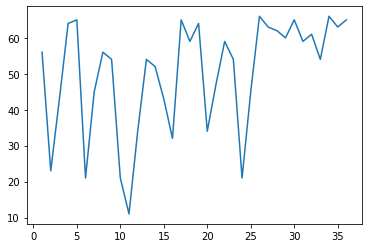

In [36]:
lines = daily_haul['Hauling_units'].plot.line()

In [ ]:
bin_width = round((daily_haul['Hauling_units'].max() - daily_haul['Hauling_units'].min())/10)
print(bin_width)

6


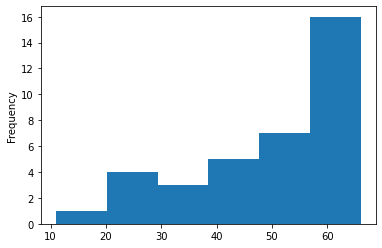

In [ ]:
haul_hist = daily_haul['Hauling_units'].plot.hist(bins=bin_width)

In order to generate the random numbers for the excavator (see below), the Coefficient of Variation would be calculated. If CV <= 0.3 then the distribution would be normal, otherwise the random numbers would be generated from a lognormal distribution. In both cases the mean and standard deviation are used as input.

In [37]:
# Calculating the mean

mean_haul = daily_haul['Hauling_units'].mean()
print (mean_haul)

50.166666666666664


In [38]:
# Calculating the standard deviation

std_dev_haul = daily_haul['Hauling_units'].std()
print (std_dev_haul)

15.725320800724997


In [39]:
# Calculating the CV

cov_haul = daily_haul['Hauling_units'].std() / daily_haul['Hauling_units'].mean()

print (cov_haul)


0.3134615442004983


# Classes defitions

To start, let's define the seams and their attributes using a Seam class.

In [40]:
class Seam():

  def __init__(self, seam, volume, units, mining_sequence, ore_type, to_stk = 0, to_dump = 0):

    self.seam = seam
    self.volume = volume
    self.units = units
    self.mining_sequence = mining_sequence
    self.ore_type = ore_type
    self.to_stk = to_stk
    self.to_dump = to_dump
    self.volumes = [volume]


  def update_volume(self, daily_dig):
    self.volume -= daily_dig
    self.volumes.append(self.volume)
    if self.ore_type == 'ore': 
      if self.volume > 0:
        self.to_stk = daily_dig
      else:
        self.to_stk = 0
    else:
      self.to_dump = daily_dig

  def show_volume(self):
    print(self.seam + " volume is " + str(self.volume) + self.units)    

Let's test if the Seam class is working by creating the overburden seam.

In [66]:
ob = Seam('Overburden', 5000, 'm3', 'seq1', 'waste')
ob.show_volume()

Overburden volume is 5000m3


Now that the overburden is created, let's add three more seams, two are ore material and an innerburden seam.

In [67]:
seam1 = Seam('Seam1', 3470, 'm3', 'seq2', 'ore')
seam1.show_volume()

Seam1 volume is 3470m3


In [68]:
seam2 = Seam('Seam2', 1250, 'm3', 'seq3', 'waste')
seam2.show_volume()

Seam2 volume is 1250m3


In [69]:
seam3 = Seam('Seam3', 2290, 'm3', 'seq4', 'ore')
seam3.show_volume()

Seam3 volume is 2290m3


Next step would be to create the excavator. Because the excavator is a key element of our operation (basically, without it we coulnd't mine, right?) it will be modeled using a class, also to include more functionality to it later on if needed. For the turn_on_excavator method the data from the "Daily Haul" spreadsheet will be used to do the simulations with the most up to date data. Also, note that the CV would be used as a guide to choose the distribution type to generate the random numbers.

In [45]:
import random

class Excavator():

  def __init__(self, make, bucket_size, bucket_units, odometer, excavator_id, daily_production, status):

    self.make = make
    self.bucket_size = bucket_size
    self.bucket_units = bucket_units
    self.odometer = odometer
    self.excavator_id = excavator_id
    self.daily_production = daily_production
    self.status = status
    self.track_daily_mine_prod = []

  def update_odometer (self, daily_hours):
    self.odometer += daily_hours
  
  def update_production (self, daily_dig):
    self.daily_production = daily_dig

  def turn_on_excavator(self, day, cv, mean, std):
    working_day = day % 7
    if working_day == 0:
      self.status = 'off'
      self.daily_production = 0
      self.track_daily_mine_prod.append(self.daily_production)
    else:
      self.status = 'on'
      if cv <= 0.3:
        self.daily_production = int(random.gauss(mean, std))
        self.track_daily_mine_prod.append(self.daily_production)
      else:
        self.daily_production = int(random.weibullvariate(mean, std))
        self.track_daily_mine_prod.append(self.daily_production)


Next let's define the stockpile object.

In [46]:
class Stockpile():

  def __init__(self, grade, volume, units, status):
    self.grade = grade
    self.volume = volume
    self.units = units
    self.status = status
    self.stk_volume = [volume]

  def update_volume_from_mining(self, hauling, recovery = 0.8):
    self.volume += int(hauling * recovery)

  def ship_to_silo(self, plant_silo):
    self.volume -= plant_silo
    self.stk_volume.append(self.volume)

  def show_stockpile(self):
    print("Stockpile volume is " + str(self.volume))

  def update_status(self):
    if self.volume <= 0:
      self.status = 'empty'
    else:
      self.status = 'with ore'

  def reset_volume(self):
    self.volume = 0

To conclude, a class plant is going to be created.

In [65]:
class Plant():


  def __init__(self, volume_silo, process_recovery, final_product_inventory, plant_status, silo_capacity, shipped_from_stk, silo_status = 'empty'):
    self.volume_silo = volume_silo
    self.process_recovery = process_recovery
    self.final_product_inventory = final_product_inventory
    self.plant_status = plant_status
    self.silo_capacity = silo_capacity
    self.shipped_from_stk = shipped_from_stk
    self.silo_status = silo_status
    self.track_silo_status = [silo_status]
    self.track_silo_volume = [volume_silo]
    self.track_plant_status = [plant_status]
    self.track_inventory_levels = [final_product_inventory]
    self.track_feed_from_stk = [shipped_from_stk]

  def update_silo_status(self):
    if self.volume_silo <= 0:
      self.silo_status = 'empty'
      self.track_silo_status.append(self.silo_status)
    elif self.volume_silo <= 100:
      self.silo_status = 'low level'
      self.track_silo_status.append(self.silo_status)
    else:
      self.silo_status = 'Operational level'
      self.track_silo_status.append(self.silo_status)


  def feed_from_stockpile(self, stk, plant_feed):
    if stk > self.silo_capacity:
      if self.plant_status == 'waiting':
        self.shipped_from_stk = self.silo_capacity - self.volume_silo
        self.volume_silo = self.volume_silo + (self.silo_capacity - self.volume_silo)
        self.track_feed_from_stk.append(self.shipped_from_stk)
      elif self.plant_status != 'waiting':
        self.shipped_from_stk = self.silo_capacity - self.volume_silo
        self.volume_silo = self.volume_silo + (self.silo_capacity - self.volume_silo)
        self.track_feed_from_stk.append(self.shipped_from_stk)
      else:
        self.shipped_from_stk = 0
        self.volume_silo += 0
        self.track_feed_from_stk.append(self.shipped_from_stk)
    elif stk > plant_feed:
      need_ore = self.silo_capacity - self.volume_silo
      if self.plant_status == 'waiting':
        self.shipped_from_stk = 0
        self.volume_silo += 0
        self.track_feed_from_stk.append(self.shipped_from_stk)
      elif need_ore > stk:
        self.shipped_from_stk = stk
        self.volume_silo += stk
        self.track_feed_from_stk.append(self.shipped_from_stk)
      else:
        self.shipped_from_stk = need_ore
        self.volume_silo += need_ore
        self.track_feed_from_stk.append(self.shipped_from_stk)
    elif stk > 0 and stk < plant_feed:
      if self.plant_status == 'waiting':
        self.shipped_from_stk = 0
        self.volume_silo += 0
        self.track_feed_from_stk.append(self.shipped_from_stk)
      else:
        self.shipped_from_stk = stk
        self.volume_silo += stk
        self.track_feed_from_stk.append(self.shipped_from_stk)
    else:
      self.shipped_from_stk = 0
      self.volume_silo = 0
      self.track_feed_from_stk.append(self.shipped_from_stk)

  def update_plant_status(self, ore_in_ground, stk):
    if ore_in_ground > 500:
      self.plant_status = 'waiting'
      self.track_plant_status.append(self.plant_status)
    elif ore_in_ground > 0:
      self.plant_status = 'Operational_level'
      self.track_plant_status.append(self.plant_status)
    elif stk > 0:
      self.plant_status = 'Operational level'
      self.track_plant_status.append(self.plant_status)
    elif self.volume_silo > 0:
      self.plant_status = 'Operational level'
      self.track_plant_status.append(self.plant_status)
    else:
      self.plant_status = 'stopped'
      self.track_plant_status.append(self.plant_status)

  def plant_production(self, daily_feed):
    if self.volume_silo >= daily_feed:
      self.volume_silo -= daily_feed
      self.final_product_inventory = int(self.final_product_inventory + (daily_feed * self.process_recovery))
      self.track_inventory_levels.append(self.final_product_inventory)
      self.track_silo_volume.append(self.volume_silo)
    elif self.volume_silo > 0 and self.volume_silo < daily_feed:
      available_in_silo = self.volume_silo
      self.volume_silo -= available_in_silo
      self.final_product_inventory = int(self.final_product_inventory + (available_in_silo * self.process_recovery))
      self.track_inventory_levels.append(self.final_product_inventory)
      self.track_silo_volume.append(self.volume_silo)
    else:
      self.volume_silo -= 0
      self.final_product_inventory = int(self.final_product_inventory + (0 * self.process_recovery))
      self.track_inventory_levels.append(self.final_product_inventory)
      self.track_silo_volume.append(self.volume_silo)

Below is the definition of the Plant class used in the simulation.

In [70]:
plant1 = Plant(0, .815, 0, 'waiting', 500, 0)
print(plant1.plant_status)
print(plant1.volume_silo)
print(plant1.silo_status)

waiting
0
empty


Now is time to create the excavator using the Excavator class defined early. For this example we are just saying that the excavator is brand new, ie, motor has "0" hours running and no daily production. Note that odometer is not included in the modeling.

In [71]:
excavator1 = Excavator('Cat', 1, 'm3', 0, 'cat1', 0, 'off')
print(excavator1.daily_production)
print(excavator1.status)

0
off


The next in the line is to create a stockpile with the class of same name, and show the stockpile volume.

In [72]:
stk1 = Stockpile('Grade1', 0, 'm3', 'empty')

In [73]:
stk1.show_stockpile()

Stockpile volume is 0


# Mining Function

Before proceeding to the simulation, a function to do the mining is prepared

In [63]:
def mining(excavator, obd, s1, s2, s3):
  if obd > 0:
    if obd > excavator:
      ob.update_volume(excavator)
    elif obd > 0 and obd < excavator:
      x = obd
      y = excavator - obd
      ob.update_volume(x)
      seam1.update_volume(y)
    else:
      ob.update_volume(0)
  elif s1 > 0:
    if s1 > excavator:
      seam1.update_volume(excavator)
    elif s1 > 0 and s1 < excavator:
      x = s1
      y = excavator - s1
      seam1.update_volume(x)
      seam2.update_volume(y)
    else:
      seam1.update_volume(0)
  elif s2 > 0:
    if s2 > excavator:
      seam2.update_volume(excavator)
    elif s2 > 0 and s2 < excavator:
      x = s2
      y = excavator - s2
      seam2.update_volume(x)
      seam3.update_volume(y)
    else:
      seam2.update_volume(0)
  elif s3 > 0:
    if s3 > excavator:
      seam3.update_volume(excavator)
    elif s3 > 0 and s3 < excavator:
      x = s3
      y = excavator - s3
      seam3.update_volume(x)
    else:
      seam3.update_volume(0)
  else:
    pass 

# Simulating the mine operation

Now that the main objects of the mine are defined, as well as the lists that will track volumes evolution and days, it is time to do a simple simulation. The approach for time advance is fixed increment time advance (1 day). 

The assumption is, once that ore is available in the stockpile, it will feed a silo with a capacity of 500 units. The silo then feeds the plant with a daily input of 35 units.

Again, let's remember that the objective of the simulation is to investigate how is the mine operation using one excavator, how fast do we deplete the cut (hence, how fast do we need to have another supply), stockpile and silo. 

A series of if then statements were used to run the simulation, some of them are repetitive. It is clear that an opportunity to improve the simulation, for example, creating a mining function -just to mention one-, exists. 

In [74]:

initial_day = 0
plant_feed = 35

while True:
  
    initial_day +=1
    ore_in_ground = seam1.volume + seam2.volume + seam3.volume

    if plant1.plant_status != 'stopped':

      excavator1.turn_on_excavator(initial_day, cov_haul, mean_haul, std_dev_haul)
      mining(excavator1.daily_production, ob.volume, seam1.volume, seam2.volume, seam3.volume)
      for_stk = seam1.to_stk + seam2.to_stk + seam3.to_stk
      stk1.update_volume_from_mining(for_stk)
      plant1.feed_from_stockpile(stk1.volume, plant_feed)
      stk1.ship_to_silo(plant1.shipped_from_stk)
      stk1.update_status()
      plant1.plant_production(plant_feed)
      plant1.update_silo_status()
      plant1.update_plant_status(ore_in_ground, stk1.volume)
  
    else:
      break

In [75]:
print(ore_in_ground)

0


In [76]:
print(ob.volumes)
print(seam1.volumes)
print(seam2.volumes)
print(seam3.volumes)

[5000, 4955, 4911, 4864, 4811, 4771, 4726, 4726, 4676, 4628, 4579, 4530, 4481, 4431, 4431, 4384, 4334, 4285, 4247, 4197, 4148, 4148, 4102, 4049, 4001, 3955, 3906, 3864, 3864, 3815, 3767, 3718, 3673, 3620, 3573, 3573, 3527, 3474, 3428, 3394, 3350, 3308, 3308, 3267, 3225, 3179, 3128, 3080, 3026, 3026, 2974, 2928, 2892, 2849, 2802, 2753, 2753, 2706, 2664, 2613, 2566, 2518, 2470, 2470, 2421, 2376, 2327, 2281, 2235, 2193, 2193, 2141, 2093, 2053, 2002, 1960, 1915, 1915, 1872, 1824, 1774, 1722, 1672, 1626, 1626, 1578, 1535, 1491, 1442, 1394, 1346, 1346, 1293, 1244, 1195, 1146, 1094, 1050, 1050, 1006, 965, 914, 861, 814, 766, 766, 723, 678, 630, 590, 549, 501, 501, 449, 402, 356, 313, 271, 222, 222, 177, 130, 79, 34, 0]
[3470, 3460, 3412, 3412, 3369, 3326, 3274, 3224, 3181, 3133, 3133, 3084, 3034, 2992, 2939, 2892, 2843, 2843, 2789, 2745, 2698, 2653, 2602, 2554, 2554, 2505, 2464, 2416, 2375, 2326, 2282, 2282, 2231, 2187, 2137, 2091, 2044, 1995, 1995, 1955, 1910, 1858, 1807, 1757, 1712, 1712, 1

In [77]:
print(for_stk)

0


In [78]:
print(seam1.to_stk)

0


In [79]:
print(seam2.to_stk)

0


In [80]:
print(seam3.to_stk)

0


In [81]:
print(excavator1.track_daily_mine_prod)

[45, 44, 47, 53, 40, 45, 0, 50, 48, 49, 49, 49, 50, 0, 47, 50, 49, 38, 50, 49, 0, 46, 53, 48, 46, 49, 42, 0, 49, 48, 49, 45, 53, 47, 0, 46, 53, 46, 34, 44, 42, 0, 41, 42, 46, 51, 48, 54, 0, 52, 46, 36, 43, 47, 49, 0, 47, 42, 51, 47, 48, 48, 0, 49, 45, 49, 46, 46, 42, 0, 52, 48, 40, 51, 42, 45, 0, 43, 48, 50, 52, 50, 46, 0, 48, 43, 44, 49, 48, 48, 0, 53, 49, 49, 49, 52, 44, 0, 44, 41, 51, 53, 47, 48, 0, 43, 45, 48, 40, 41, 48, 0, 52, 47, 46, 43, 42, 49, 0, 45, 47, 51, 45, 44, 48, 0, 43, 43, 52, 50, 43, 48, 0, 49, 50, 42, 53, 47, 49, 0, 54, 44, 47, 45, 51, 48, 0, 49, 41, 48, 41, 49, 44, 0, 51, 44, 50, 46, 47, 49, 0, 40, 45, 52, 51, 50, 45, 0, 54, 39, 46, 56, 49, 52, 0, 42, 48, 50, 48, 37, 51, 0, 49, 52, 47, 50, 45, 48, 0, 47, 54, 44, 51, 53, 47, 0, 52, 45, 42, 53, 47, 55, 0, 47, 51, 51, 50, 48, 48, 0, 49, 44, 42, 46, 49, 50, 0, 49, 49, 51, 49, 51, 47, 0, 45, 57, 52, 49, 56, 49, 0, 51, 49, 42, 50, 49, 46, 0, 48, 42, 46, 48, 50, 46, 0, 46, 53, 47, 47, 50, 51, 0, 49, 49, 48, 51, 51, 47, 0, 

In [82]:
print(plant1.track_feed_from_stk)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 0, 0, 0, 0, 0, 210, 35, 35, 30, 36, 39, 35, 35, 35, 35, 8, 0, 0]


In [85]:
print(len(plant1.track_feed_from_stk))

297


In [86]:
print(stk1.stk_volume)
# There are many similar consecutive numbers, I think is the loop that feed from the stk to
# the silo, need to fix that later. Main focus is to write data back
# into GS to compare real vs simulation and to present these results
# to managers

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 46, 46, 80, 114, 155, 195, 229, 267, 267, 306, 346, 379, 421, 458, 497, 497, 40, 75, 112, 148, 188, 226, 226, 265, 297, 335, 367, 406, 441, 441, 481, 16, 56, 92, 129, 168, 168, 200, 236, 277, 317, 357, 393, 393, 436, 467, 3, 47, 86, 127, 127, 160, 198, 238, 276, 305, 345, 345, 384, 425, 462, 2, 38, 76, 76, 113, 156, 191, 231, 273, 310, 310, 351, 387, 420, 462, 499, 43, 43, 80, 120, 160, 200, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 242, 275, 311, 349, 389, 425, 425, 461, 3, 40, 77, 117, 157, 157, 196, 235

In [88]:
print(len(stk1.stk_volume))

297


In [89]:
print(plant1.track_plant_status)

['waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting', 'waiting'

In [90]:
print(plant1.track_silo_status)

['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 

In [91]:
print(plant1.track_silo_volume)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 465, 430, 395, 360, 325, 290, 255, 220, 185, 150, 115, 80, 45, 10, 0, 465, 430, 395, 360, 325, 290, 255, 220, 185, 150, 115, 80, 45, 10, 0, 465, 430, 395, 360, 325, 290, 255, 220, 185, 150, 115, 80, 45, 10, 0, 465, 430, 395, 360, 325, 290, 255, 220, 185, 150, 115, 80, 45, 10, 0, 0, 465, 430, 395, 360, 325, 290, 255, 220, 185, 150, 115, 80, 45, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 465, 430, 395, 360, 325, 290, 255, 220, 185, 150, 115, 80, 45, 10, 0, 0, 465, 430, 395, 360, 325, 290, 255, 220, 185, 150, 115, 80, 4

# Results

Once the simulation ends running, let's write the results back to Google Sheets in order to communicate and to store the results for comparations. The link to the spreadsheet where the results are stored is [here](https://docs.google.com/spreadsheets/d/1KndJwDmBGuw89QUCqFEAzy1C0VIeTwVkzSZ4yOoOieQ/edit?usp=sharing)



In [92]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('Results').sheet1

In [93]:
obs = []

In [94]:
obs.append(ob.volumes)

In [95]:
for j in range(len(obs)):
  for i in range(len(obs[0])):
    worksheet.update_cell(i+2, j+1, (obs[j][i]))

In [ ]:
s1_ev = [seam1.volumes]

In [ ]:
s2_ev = [seam2.volumes]

In [ ]:
s3_ev = [seam3.volumes]

In [ ]:
stk_ev = [stk1.stk_volume]

In [ ]:
for j in range(len(s1_ev)):
  for i in range(len(s1_ev[0])):
    worksheet.update_cell(i+2, j+2, (s1_ev[j][i]))

In [ ]:
for j in range(len(s2_ev)):
  for i in range(len(s2_ev[0])):
    worksheet.update_cell(i+2, j+3, (s2_ev[j][i]))

In [ ]:
for j in range(len(s3_ev)):
  for i in range(len(s3_ev[0])):
    worksheet.update_cell(i+2, j+4, (s3_ev[j][i]))

In [ ]:
for j in range(len(stk_ev)):
  for i in range(len(stk_ev[0])):
    worksheet.update_cell(i+2, j+5, (stk_ev[j][i]))